The various Random Forest model results might vary from different runs, but 3 runs are recorded each, and the mean calculated for comparison.

# Packages Imports

In [195]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Load Hyperparam best_params

/kaggle/input/rfhyperparam1/best_params/optunaRF9selunder_best_params.json
/kaggle/input/rfhyperparam1/best_params/gridsearch_best_params.json
/kaggle/input/rfhyperparam1/best_params/optunaRF1_best_params.json
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv


In [196]:
import filecmp # compare file contents
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
# RF Model Training
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report # Feature-Importance-Based Undersampling
import joblib # save trained model
import json # save training results in json
from sklearn.feature_selection import SelectKBest, f_classif # ANOVA, feature selection tool
from imblearn.under_sampling import RandomUnderSampler # undersampling
from sklearn.model_selection import GridSearchCV # hyperparameter optimization grid search
import optuna # hyperparameter optimization bayes
from sklearn.model_selection import cross_val_score
# XAI
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Analyze Dataset

In [197]:
# Check if duplicate files in different paths are identical
# Define file paths
original_files = [
    "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv",
    "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv",
    "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
]
duplicate_files = [
    "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv",
    "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv",
    "/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
]
# Compare each pair of files
for orig, dup in zip(original_files, duplicate_files):
    if filecmp.cmp(orig, dup, shallow=False): # shallow=False does a deep comparison
        print(f"Files are identical: {orig} and {dup}")
    else:
        print(f"Files are different: {orig} and {dup}")

Files are identical: /kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv and /kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv
Files are identical: /kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv and /kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
Files are identical: /kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv and /kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv


In [198]:
# Load .csv-data to DataFrame for model training
df_classes = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_edges = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [199]:
# Check for Missing Values in All Three Datasets
print("Missing values in df_classes:", df_classes.isna().sum().any())
print("Missing values in df_features:", df_features.isna().sum().any())
print("Missing values in df_edges:", df_edges.isna().sum().any())

Missing values in df_classes: False
Missing values in df_features: False
Missing values in df_edges: False


# Data Preprocessing

In [200]:
# Renaming Column Header for df_features
headerNames1 = {0: "txId", 1: "Time step"}
headerNames2 = {str(ii+2): "LocFeature_" + str(ii+1) for ii in range(93)}
headerNames3 = {str(ii+95): "AggFeature_" + str(ii+1) for ii in range(72)}

headerNames = dict(headerNames1, **headerNames2, **headerNames3 )
headerNames = {int(jj): item_kk for jj,item_kk in headerNames.items()}

df_features = df_features.rename(columns=headerNames)
df_features.head() # Check

,txId,Time step,LocFeature_1,LocFeature_2,LocFeature_3,LocFeature_4,LocFeature_5,LocFeature_6,LocFeature_7,LocFeature_8,...,AggFeature_63,AggFeature_64,AggFeature_65,AggFeature_66,AggFeature_67,AggFeature_68,AggFeature_69,AggFeature_70,AggFeature_71,AggFeature_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [201]:
# Change "unknown" to "3" in "class" column of "df_classes", numerical input for ML model
df_classes.loc[df_classes["class"] == "unknown", "class"] = 3;

# Check renaming "unknown" to "3"
print(f'Occurrences of "unknown": {(df_classes["class"] == "unknown").sum()}');
print("class value distribution:\n", df_classes["class"].value_counts());

Occurrences of "unknown": 0
class value distribution:
 class
3    157205
2     42019
1      4545
Name: count, dtype: int64


In [202]:
# Merge Class and features for EDA and Random Forest (RF)
df_class_feature = pd.merge(df_classes, df_features )
df_class_feature.head() # Check

,txId,class,Time step,LocFeature_1,LocFeature_2,LocFeature_3,LocFeature_4,LocFeature_5,LocFeature_6,LocFeature_7,...,AggFeature_63,AggFeature_64,AggFeature_65,AggFeature_66,AggFeature_67,AggFeature_68,AggFeature_69,AggFeature_70,AggFeature_71,AggFeature_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [203]:
# DataFrame without "unknown trancactions (class 3)"
selected_ids = df_class_feature.loc[(df_class_feature["class"] != 3), "txId"] # exclude "unknown" transactions
df_edges_selected = df_edges.loc[df_edges["txId1"].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes["txId"].isin(selected_ids)]
df_features_selected = df_features.loc[df_features["txId"].isin(selected_ids)]

# Merge Class and features
df_class_feature_knownclass = pd.merge(df_classes_selected, df_features_selected)
df_class_feature_knownclass.head()

# Check class_value distribution
print("Class value distribution with unknown class:\n", df_classes["class"].value_counts());
print();
print("Class value distribution without unknown class:\n", df_class_feature_knownclass["class"].value_counts());

Class value distribution with unknown class:
 class
3    157205
2     42019
1      4545
Name: count, dtype: int64

Class value distribution without unknown class:
 class
2    42019
1     4545
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

In [204]:
# Indentify shape of classes
print("Shape of classes", df_classes.shape)
print("Shape of edges", df_edges.shape)
print("Shape of features", df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


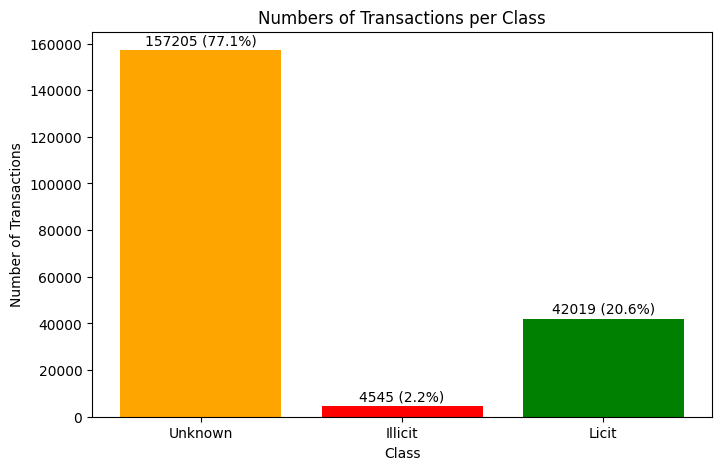

In [205]:
# Bar Chart: Numbers of Transactions per Class
# Group by class and count transactions
group_class = df_classes.groupby('class').count()

# Define class labels and colors
class_labels = ['Unknown', 'Illicit', 'Licit']
colors = ['orange', 'red', 'green']

# Calculate total transactions for percentage calculation
total_transactions = group_class['txId'].sum()

# Create a vertical bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(class_labels, group_class['txId'].values, color=colors)  # bar() for vertical bars

# Add absolute numbers and percentages above bars
for bar, value in zip(bars, group_class['txId'].values):
    percentage = (value / total_transactions) * 100  # Calculate percentage
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,  # Position text above bars
            f'{int(value)} ({percentage:.1f}%)', ha='center', va='bottom', fontsize=10, color='black')

# Title and Label Descrptions
ax.set_ylabel("Number of Transactions")  # Y-axis label
ax.set_xlabel("Class") # X-axis label
ax.set_title("Numbers of Transactions per Class")  # Title

plt.show() # Show the plot

*The dataset is imbalanced with illicit (42019) and licit (157205) transactions. The licit transactions occure 9.25 times more frequently, which represent a significant class imbalance. Techniques like under-, oversampling and class weighing are countermeasures.*

Text(0.5, 1.0, 'Number of transactions by Time step')

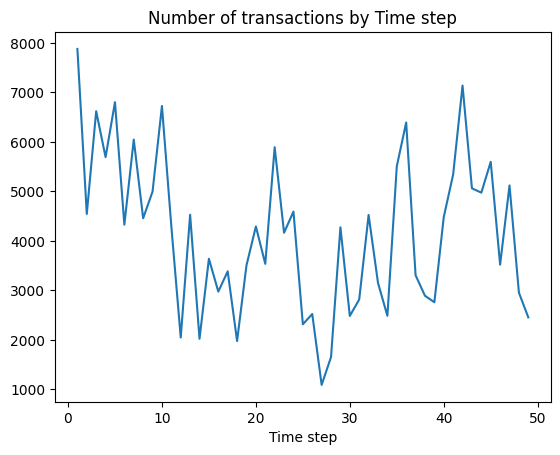

In [206]:
# Line Chart: Number of transactions per Time step
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

*The 49 time steps have an interval of about two weeks, thereof they cover a duration of 26,5 months. The line chart displays the heights and lows of transactions conducted over the time period. Overall more transactions (>4000), occur in the first 10 time steps. Furthermore transaction heights (>= 6000 transactions) are reached in time step 1, 3,5, 7, 10, 23, 36, 42. Merely little over 1000 transactions were conducted in time step 27, which reflect the lowest peak.*

In [207]:
# Line Chart: Number of transactions timestep and per class 
# Group by Time step & class, then count transactions
group_timestepclass = df_class_feature.groupby(["Time step", "class"]).count()

# Convert the index back into columns & rename for clarity
group_class_feature = group_timestepclass['txId'].reset_index().rename(columns={'txId': 'count'})
group_class_feature.head()

,Time step,class,count
0,1,3,5733
1,1,1,17
2,1,2,2130
3,2,3,3427
4,2,1,18


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

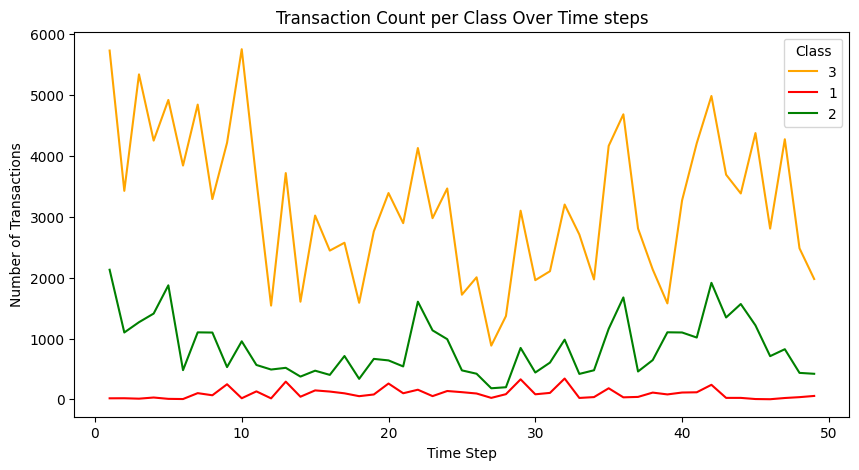

In [208]:
# Plot the line chart
plt.figure(figsize=(10, 5))
sns.lineplot(x='Time step', y='count', hue='class', data=group_class_feature, palette=['orange', 'r','g'])

# Title and Label Descrptions
plt.xlabel("Time Step")
plt.ylabel("Number of Transactions")
plt.title("Transaction Count per Class Over Time steps")
plt.legend(title="Class")  # Legend title

plt.show()
# Try solving Warnings failed, can be ignored by now

*Here we see that licit transactions overall outnumber illicit transactions at every time step [1]. Predominantly higher peaks for licit transactions occur in time steps 1, 5, something over 23, 37 and 42. Further, the number of illicit transactions does correlate in some peaks with licit transacitons at time step 13, 20, 29, 32, 35 and 42.*

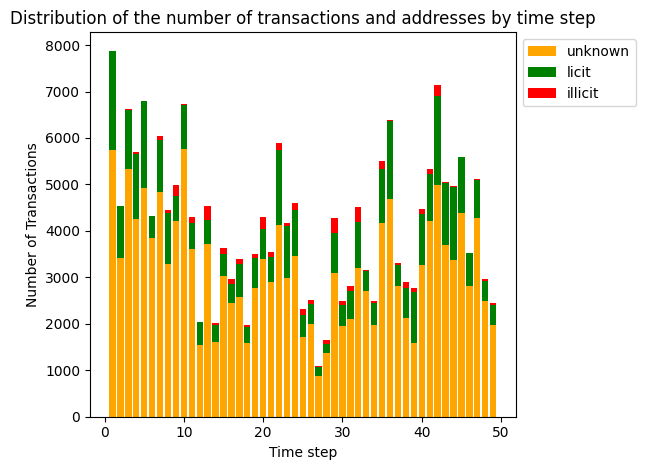

In [209]:
# Stacked Bar Chart: Distribution of the number of transactions and addresses by time step
class1 = group_class_feature[group_class_feature['class'] == "1" ] # illicit
class2 = group_class_feature[group_class_feature['class'] == "2" ] # licit
class3 = group_class_feature[group_class_feature['class'] == 3 ] # unknown

# Stacked bar chart
p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange', label = 'unknown')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'], label = 'licit')

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']),
            label = 'illicit')

plt.title("Distribution of the number of transactions and addresses by time step")
plt.xlabel("Time step")
plt.ylabel("Number of Transactions")
plt.legend(bbox_to_anchor=(1,1)) # legend outside chart
plt.tight_layout()
plt.show()

*As reflected in the peaks of the line chart above, time steps 9, 13, 20, 29, 32 and 42 contains more fraudulent transactions.*

# Role of Performance Metrics for fraud detection

In fraud detection, it is important to have less false negatives, i.e. avoid to detect illicit transactions as licit. Therefore a high recall is priortized with a trade-off for precision [2]. 
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Because of the imbalanced nature of the dataset, Martinez et al. considers the F1-Score the most important, as it provides a balanced measure of a model’s performance, combining both precision and recall (sensitivity) [1]. As both measures consider positive predictions, the effect of an imbalanced dataset with e.g. a majority negative class will not be reflected as much in the metric, as in precision or recall alone [3].
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

# Random Forest

**1. Training Version (RF1): default model 100 trees, original dataset**

In [210]:
# define X, y for RF
X = df_class_feature_knownclass.drop(columns=["txId", "class", "Time step"])
y = df_class_feature_knownclass[["class"]]
y = y['class'].apply(lambda x: 0 if x == '2' else 1 ) # Converts class labels into a binary format: class 2 (licit) to 0, class 1 (illicit) to 1

In [211]:
# Split into Train(75%)/Test(25%) Set:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42, stratify=y)
# Check Dataset Shapes (Rows in Each Split)
print(f"Total dataset size: {X.shape[0]} rows")
print(f"Training set: {X_train.shape[0]} rows ({X_train.shape[0] / X.shape[0] * 100:.2f}%)")
print(f"Test set: {X_test.shape[0]} rows ({X_test.shape[0] / X.shape[0] * 100:.2f}%)")

Total dataset size: 46564 rows
Training set: 34923 rows (75.00%)
Test set: 11641 rows (25.00%)


Total dataset size: 46564 rows  
Training set: 34923 rows (75.00%)  
Test set: 11641 rows (25.00%)  

For the approaches undertaken here, a split into 2 sets, training (75%) and test set (25%) will be sufficient.

In [ ]:
# 1. Random Forest Classifier (default 100 trees, split1: Train(75%)/Test Split(25%))

# Train the RF model (default has 100 trees, random_state=42 (rs=42), split1)
model_RF1 = RandomForestClassifier(random_state=42).fit(X_train.values,y_train.values)

# Make predictions on both Train and Test sets
y_preds_train = model_RF1.predict(X_train.values)  # Predict on training set
y_preds_test = model_RF1.predict(X_test.values)  # Predict on test set

# Compute precision, recall, F1-score, and accuracy for both train and test sets
prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train, y_preds_train)
accuracy_train = accuracy_score(y_train, y_preds_train)

prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test, y_preds_test)
accuracy_test = accuracy_score(y_test, y_preds_test)

# Print results for both train and test sets
print("Random Forest Classifier RF1")

print("Train Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_train[1], rec_train[1], f1_train[1], accuracy_train))

print("\nTest Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_test[1], rec_test[1], f1_test[1], accuracy_test))

joblib.dump(model_RF1, "model_RF1.pkl") #Save trained model

*Test Performance Result Interpretation (can be applied to all model results):*  
*Precision: 99.6%  of the transactions predicted as illicit (true + false positives) are actually illicit (true positives). 0.4% of the positive predictions were licit transactions.  
Recall: 87.1% of the illicit transactions (true positives) were detected out of all transactions (true positives and fals negatives). 12.9% of the illicit transactions were not detected.  
F1 Score: 92.9% is the balanced measure of precision and recall, important as our dataset is imbalanced.  
Accuracy: 98.7% of the instances are correctly classified.*  

*Compare Trainig and Test Performance to indicate Over-/Underfitting:*  
*The almost perfect metrics for training set indicates that the model has learned well, but it also indicates overfitting, especially compared to the drop for recall and F1 score in the test data.  
Overfitting means, the model captures noise and details specific to the training data, which will not generalize as well to new, unseen data. Possible reasons: imbalanced dataset can make the model favor the majority class.*

RF1 Test Performances over multiple runs (1.run; 2. run; ...):  
Train Performance  
1.000, 1.000, 1.000  Precision  
0.999, 0.999, 0.999  Recall  
1.000, 1.000, 1.000  F1 Score  
1.000, 1.000, 1.000  Accuracy  
Test Performance  
0.996, 0.996, 0.996   Precision mean: 0.996  
0.871, 0.871, 0.871  Recall     mean: 0.871  
0.929, 0.929, 0.929  F1 Score   mean: 0.929  
0.986, 0.987, 0.987  Accuracy   mean: 0.987  

With random_state=42, results vary sometimes (tried 3 times: 2. same, 3. different) 
Without random_state, results vary slightly with every run (tried 3 times)

**2. Training Version (RF2): Hyperparameter 200 trees**

In [ ]:
# Train the RF2 model (200 trees, random_state=42 (rs=42), split1)
model_RF2 = RandomForestClassifier(n_estimators=200,random_state=42).fit(X_train.values,y_train.values)

# Make predictions on both Train and Test sets
y_preds_train = model_RF2.predict(X_train.values)  # Predict on training set
y_preds_test = model_RF2.predict(X_test.values)  # Predict on test set

# Compute precision, recall, F1-score, and accuracy for both train and test sets
prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train, y_preds_train)
accuracy_train = accuracy_score(y_train, y_preds_train)

prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test, y_preds_test)
accuracy_test = accuracy_score(y_test, y_preds_test)

# Print results for both train and test sets
print("Random Forest Classifier RF2") # should be RF2, edited after run

print("Train Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_train[1], rec_train[1], f1_train[1], accuracy_train))

print("\nTest Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_test[1], rec_test[1], f1_test[1], accuracy_test))

*More trees generally lead to more stable and consistent predictions, as the ensemble effect is stronger. Increasing the number of trees to 200 can lead to a slight improvement in performance, as the model has more trees to average out predictions, reducing variance and potentially improving generalization. On the other hand it increases the risk for overfitting, if the trees are too deep or complex.  
In this case it slightly improved the performance metrics (precision 0.0002, recall 0.002, F1-Score, 0.002), but the accuracy stays the same, meaning the correctly classified instances among the total were the same.*

In a previous run it had same results as 100 trees
RF2 200 trees:  
Train Performance: 3 times results all "1"  
Test Performance:  
0.997, 0.998, 0.998  Precision  mean: 0.998  
0.863, 0.863, 0.873  Recall     mean: 0.866  
0.925, 0.931, 0.931  F1 Score   mean: 0.929  
0.986, 0.987, 0.987  Accuracy   mean: 0.987

**3. Training Version : Split2: Train(60%)/Val(20%)/Test(20%), 100 and 200 trees**

This training version with a split to training (60%), validation (20%) and test (20%) set was intended to get deleted, but kept because the insights are still valuable. 

As the results are contrary to the above results, here more trees had the same or less performance, this indicate that model's result variation has to be considered in the interpretations of results, especially as the result differences are minimal.

In [ ]:
# Split into Train(60%)/Val(20%)/Test(20%) Set:
# First, split into train and temp ( temp contains validation + test)
X_train_split2, X_temp, y_train_split2, y_temp = train_test_split(X,y, test_size=0.40, random_state=42, stratify=y)
# Second, split temp into validation and test sets
X_val_split2, X_test_split2, y_val_split2, y_test_split2 = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Check Dataset Shapes (Rows in Each Split)
print(f"Total dataset size: {X.shape[0]} rows")
print(f"Training set: {X_train_split2.shape[0]} rows ({X_train_split2.shape[0] / X.shape[0] * 100:.2f}%)")
print(f"Validation set: {X_val_split2.shape[0]} rows ({X_val_split2.shape[0] / X.shape[0] * 100:.2f}%)")
print(f"Test set: {X_test_split2.shape[0]} rows ({X_test_split2.shape[0] / X.shape[0] * 100:.2f}%)")

Total dataset size: 46564 rows  
Training set: 27938 rows (60.00%)  
Validation set: 9313 rows (20.00%)  
Test set: 9313 rows (20.00%)  

In [ ]:
# Random Forest Classifier model_RF100rs42s2, Split2: Train(60%)/Val(20%)/Test(20%)
# 2. Train the RF model (default has 100 trees, random_state=42, split2)
model_RF100rs42s2 = RandomForestClassifier(random_state=42).fit(X_train_split2.values,y_train_split2.values)

# Make predictions on both Train and Test sets
y_preds_train_split2 = model_RF100rs42s2.predict(X_train_split2.values)  # Predict on training set
y_preds_val_split2 = model_RF100rs42s2.predict(X_val_split2.values) # predict on validation set

# Compute precision, recall, F1-score, and accuracy for both train and val sets
prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train_split2, y_preds_train_split2)
accuracy_train = accuracy_score(y_train_split2, y_preds_train_split2)

prec_val, rec_val, f1_val, _ = precision_recall_fscore_support(y_val_split2.values, y_preds_val_split2)
accuracy_val = accuracy_score(y_val_split2.values, y_preds_val_split2)

# Print results for both train and val sets
print("RF100rs42s2 split1 100 trees") # should be RF2, edited after run

print("Train Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_train[1], rec_train[1], f1_train[1], accuracy_train))

print("\nTest Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_val[1], rec_val[1], f1_val[1], accuracy_val))

RF2RF100rs42s2, split2, 100 trees, random_state=42 - Results:  
Train Performance: 3 times results all "1"
Test Performance:  
0.998, 0.998, 0.998   Precision  mean: 0.998  
0.878, 0.878, 0.878   Recall     mean: 0.878  
0.934, 0.934, 0.934   F1 Score   mean: 0.934  
0.988, 0.988, 0.988   Accuracy   mean: 0.988  
*Observance: A split into Train(60%)/Val(20%)/Test(20%) (training set of 27938 transactions) achieved slightly better results than in RF1 with Train(75%)/Test(25%) (training set of 34923 transactions).*

In [ ]:
# Random Forest Classifier RF200rs42, Split3: Train(60%)/Val(20%)/Test(20%)
# Train the RF model (200 trees, random_state=42, split2)
model_RF200rs42s2 = RandomForestClassifier(n_estimators=200, random_state=42)
model_RF200rs42s2.fit(X_train_split2.values,y_train_split2.values)

# Make predictions on both Train and Test sets
y_preds_train_split2 = model_RF200rs42s2.predict(X_train_split2.values)  # Predict on training set
y_preds_val_split2 = model_RF200rs42s2.predict(X_val_split2.values) # predict on validation set

# Compute precision, recall, F1-score, and accuracy for both train and val sets
prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train_split2, y_preds_train_split2)
accuracy_train = accuracy_score(y_train_split2, y_preds_train_split2)

prec_val, rec_val, f1_val, _ = precision_recall_fscore_support(y_val_split2.values, y_preds_val_split2)
accuracy_val = accuracy_score(y_val_split2.values, y_preds_val_split2)

# Print results for both train and val sets
print("RF200rs42s2 split2")

print("Train Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_train[1], rec_train[1], f1_train[1], accuracy_train))

print("\nTest Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_val[1], rec_val[1], f1_val[1], accuracy_val))

RF200rs42s2, split2, 200 trees, random_state=42  
Train Performance: 3 times results all "1"  
Precision: 0.997  
Recall: 0.872  
F1 Score: 0.931  
Accuracy: 0.987  

0.997, 0.997, 0.997   Precision  mean: 0.997  
0.872, 0.872, 0.872   Recall     mean: 0.872  
0.931, 0.931, 0.931   F1 Score   mean: 0.931  
0.987, 0.987, 0.987   Accuracy   mean: 0.987  

*Version "without random_state=42": The results for " RF with 200 trees without random_state=42" are the same as "RF with 100 trees without random_state=42".  
But after adding random_state=42 in the "100 tree" and "200 tree" model, results for 200 trees were slightly lower in all metrics (<0.006).*

# RF Feature Selection (ANOVA)

**1. Selecting the most important feature with statistical test ANOVA (calculating F-values for each feature)**  
done in article [1]

In [ ]:
# Define K as half the number of features
k = X_train.shape[1] // 2

# Create the selector with the ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=k)

# Fit the selector on the training data and transform the training set
X_train_selected = selector.fit_transform(X_train, y_train)

# Transform the test set using the fitted selector
X_test_selected = selector.transform(X_test)

In [ ]:
# 5. RF5 (feature selected, 100 trees, rs=42, split1), train the RF5 3x and calculate mean metric
def train_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, random_state=42):
    model_RF5 = RandomForestClassifier(n_estimators=100, random_state=random_state)
    model_RF5.fit(X_train_selected, y_train.values)
    
    # Make predictions on both Train and Test sets
    y_preds_train = model_RF5.predict(X_train_selected)
    y_preds_test = model_RF5.predict(X_test_selected)
    
    # Compute precision, recall, F1-score, and accuracy for both train and test sets
    prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train, y_preds_train)
    accuracy_train = accuracy_score(y_train, y_preds_train)
    
    prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test, y_preds_test)
    accuracy_test = accuracy_score(y_test, y_preds_test)
    
    # Store results in a dictionary
    results = {
        "Train Precision": prec_train[1],
        "Train Recall": rec_train[1],
        "Train F1 Score": f1_train[1],
        "Train Accuracy": accuracy_train,
        "Test Precision": prec_test[1],
        "Test Recall": rec_test[1],
        "Test F1 Score": f1_test[1],
        "Test Accuracy": accuracy_test
    }
    
    return model_RF5, results

# List to store results of each run
results_list = []

# Perform 3 runs
for i in range(3):
    model_RF5, results = train_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, random_state=42+i)
    results_list.append(results)
    joblib.dump(model_RF5, f"random_forest_model_run_{i+1}.pkl")

# Calculate mean of the results
mean_results = {
    "Train Precision": np.mean([result["Train Precision"] for result in results_list]),
    "Train Recall": np.mean([result["Train Recall"] for result in results_list]),
    "Train F1 Score": np.mean([result["Train F1 Score"] for result in results_list]),
    "Train Accuracy": np.mean([result["Train Accuracy"] for result in results_list]),
    "Test Precision": np.mean([result["Test Precision"] for result in results_list]),
    "Test Recall": np.mean([result["Test Recall"] for result in results_list]),
    "Test F1 Score": np.mean([result["Test F1 Score"] for result in results_list]),
    "Test Accuracy": np.mean([result["Test Accuracy"] for result in results_list])
}

print("Mean Results after 3 runs:", mean_results)

Mean Results after 3 runs: {  
'Train Precision': 1.0,  
'Train Recall': 1.0,  
'Train F1 Score': 1.0,   
'Train Accuracy': 1.0,  
'Test Precision': 0.9962191341561675,  
'Test Recall': 0.8485915492957746,  
'Test F1 Score': 0.9164932981337497,   
'Test Accuracy': 0.984909658391318}  
*Exact same results as RF2 (200 trees). Previous results where exact the same as a former runs of RF1 without feature selection*

# RF Undersamling

**1. Random Undersampling to a 3:1 ratio**

In [ ]:
# Random Undersampling to a 3:1 ratio
# X and y already defined above

# Define the desired ratio (3:1)
target_class_1 = sum(y == 1)  # Number of illicit transactions (4,545)
target_class_0 = target_class_1 * 3  # Target number of licit transactions (3x minority class)

# Initialize the undersampler with a specific class ratio
rus = RandomUnderSampler(sampling_strategy={0: target_class_0, 1: target_class_1}, random_state=42)

# Apply undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Verify class distribution after undersampling
print(y_resampled.value_counts()) 

In [ ]:
# Train RF6, Random Undersampling, mean calculated afer 3 runs
# Split undersampled datset into train (75%), and test (25%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled)

#Train RF6 Random undersampling
model_RF6 = RandomForestClassifier().fit(X_train.values,y_train.values)

y_preds_train = model_RF6.predict(X_train.values)  # Predict on training set
y_preds_test = model_RF6.predict(X_test.values)  # Predict on test set

# Compute precision, recall, F1-score, and accuracy for both train and test sets
prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train, y_preds_train)
accuracy_train = accuracy_score(y_train, y_preds_train)

prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test, y_preds_test)
accuracy_test = accuracy_score(y_test, y_preds_test)

# Print results for both train and test sets
print("RF6 random undersampling")
print("Train Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_train[1], rec_train[1], f1_train[1], accuracy_train))

print("\nTest Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_test[1], rec_test[1], f1_test[1], accuracy_test))

RF6 random undersampling  
0.994, 0.992, 0.992  Precision  mean: 0.993  
0.894, 0.896, 0.891  Recall  mean: 0.894  
0.942, 0.942, 0.939  F1 Score  mean: 0.941  
0.972, 0.972, 0.971  Accuracy  mean: 0.972  

**2. Undersampling Based on Feature Importance**  
Keeping Licit Transactions with High Feature Importance based on random forest feature importance

In [ ]:
#Load pre-trained model
model_RF1 = joblib.load("model_RF1.pkl")

# Get feature importances
feature_importances = model_RF1.feature_importances_

# Compute transaction-level importance scores
importance_scores = np.dot(X_train, feature_importances)

# Add importance scores to X_train
X_train_with_importance = X_train.copy()
X_train_with_importance["importance_score"] = importance_scores
# X_train = pd.concat([X_train, pd.Series(importance_scores, index=X_train.index, name="importance_score")], axis=1)

# Retain the top-K most important licit transactions
top_k_licit = X_train_with_importance[y_train == 0].nlargest(13635, "importance_score")
df_balanced = pd.concat([top_k_licit, X_train_with_importance[y_train == 1]])

In [ ]:
# Debug: Check if there is only ONE importance_score column
print("Columns in X_train after fix:", X_train.columns)

In [ ]:
# Define X_balanced and y_balanced
X_balanced = df_balanced.drop(columns=["importance_score"])  # Drop the importance column
y_balanced = y_train.loc[df_balanced.index]  # Ensure correct indexing for labels

# Debugging step: Verify the new dataset's distribution
print("New dataset shape:", X_balanced.shape)
print("Licit transactions in balanced dataset:", (y_balanced == 0).sum())
print("Illicit transactions in balanced dataset:", (y_balanced == 1).sum())

In [ ]:
# Split into train (75%) and test (25%) sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42, stratify=y_balanced
)

# Debug: Check new class distribution after splitting
print("Training set shape:", X_train_bal.shape)
print("Test set shape:", X_test_bal.shape)
print("Licit transactions in train set:", (y_train_bal == 0).sum())
print("Illicit transactions in train set:", (y_train_bal == 1).sum())
print("Licit transactions in test set:", (y_test_bal == 0).sum())
print("Illicit transactions in test set:", (y_test_bal == 1).sum())

In [ ]:
# Train the RF model on the feature selected undersampled dataset
model_RF7 = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF7.fit(X_train_bal, y_train_bal)

# Make predictions
y_preds_train_bal = model_RF7.predict(X_train_bal)
y_preds_test_bal = model_RF7.predict(X_test_bal)

# Compute metrics for train set
prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train_bal, y_preds_train_bal)
accuracy_train = accuracy_score(y_train_bal, y_preds_train_bal)

# Compute metrics for test set
prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test_bal, y_preds_test_bal)
accuracy_test = accuracy_score(y_test_bal, y_preds_test_bal)

print("RF7 RF-feature undersampling")
print("Train Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_train[1], rec_train[1], f1_train[1], accuracy_train))

print("\nTest Performance")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f \nAccuracy: %.3f" % 
      (prec_test[1], rec_test[1], f1_test[1], accuracy_test))

RF7 RF-feature selected undersampling  
Train Performance: 3 times results all "1"  
Test Performance:  
0.998, 0.998, 0.998  Precision  mean: 0.998  
0.984, 0.984, 0.984  Recall  mean: 0.984  
0.991, 0.991, 0.991  F1 Score  mean: 0.991  
0.996, 0.996, 0.996  Accuracy  mean: 0.996  

# Hyperparameter Optimization
Optimiziation results (long run)  are stored as and retrieved from the rfhyperparam1 dataset.

In [ ]:
# Define the parameter grid for GridSearchCV on feature selected undersampling
# Results stored in: /kaggle/input/rfhyperparam1/best_params/gridsearch_best_params.json
"""
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# Fitting 5 folds for each of 324 candidates, totalling 1620 fits
# Fit the model using GridSearchCV
grid_search.fit(X_train_bal, y_train_bal)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
"""

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
# Load stored best_params
with open("/kaggle/input/rfhyperparam1/best_params/gridsearch_best_params.json", "r") as f:
    best_params_RF8 = json.load(f)
print(best_params_RF9)

In [ ]:
# RF8 optimal hyperparameters: run 3x, mean
def train_and_evaluate(X_train_bal, y_train_bal, X_test_bal, y_test_bal, best_params, random_state=42):
    model_RF8 = RandomForestClassifier(**best_params_RF8, random_state=random_state)
    model_RF8.fit(X_train_bal, y_train_bal)
    
    # Make predictions on both Train and Test sets
    y_preds_train_bal = model_RF8.predict(X_train_bal)
    y_preds_test_bal = model_RF8.predict(X_test_bal)
    
    # Compute precision, recall, F1-score, and accuracy for both train and test sets
    prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train_bal, y_preds_train_bal)
    accuracy_train = accuracy_score(y_train_bal, y_preds_train_bal)
    
    prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test_bal, y_preds_test_bal)
    accuracy_test = accuracy_score(y_test_bal, y_preds_test_bal)
    
    # Store results in a dictionary
    results = {
        "Train Precision": prec_train[1],
        "Train Recall": rec_train[1],
        "Train F1 Score": f1_train[1],
        "Train Accuracy": accuracy_train,
        "Test Precision": prec_test[1],
        "Test Recall": rec_test[1],
        "Test F1 Score": f1_test[1],
        "Test Accuracy": accuracy_test
    }
    
    return model_RF8, results

# List to store results of each run
results_list = []

# Perform 3 runs
for i in range(3):
    model_RF8, results = train_and_evaluate(X_train_bal, y_train_bal, X_test_bal, y_test_bal, best_params, random_state=42+i)
    results_list.append(results)
    joblib.dump(model_RF8, f"random_forest_model_run_{i+1}.pkl")

        # Print intermediate results
    print(f"Results after run {i+1}:")
    print("Train Performance")
    print(f"Precision: {results['Train Precision']:.3f}")
    print(f"Recall: {results['Train Recall']:.3f}")
    print(f"F1 Score: {results['Train F1 Score']:.3f}")
    print(f"Accuracy: {results['Train Accuracy']:.3f}")
    print("Test Performance")
    print(f"Precision: {results['Test Precision']:.3f}")
    print(f"Recall: {results['Test Recall']:.3f}")
    print(f"F1 Score: {results['Test F1 Score']:.3f}")
    print(f"Accuracy: {results['Test Accuracy']:.3f}")
    print()

# Calculate mean of the results
mean_results = {
    "Train Precision": np.mean([result["Train Precision"] for result in results_list]),
    "Train Recall": np.mean([result["Train Recall"] for result in results_list]),
    "Train F1 Score": np.mean([result["Train F1 Score"] for result in results_list]),
    "Train Accuracy": np.mean([result["Train Accuracy"] for result in results_list]),
    "Test Precision": np.mean([result["Test Precision"] for result in results_list]),
    "Test Recall": np.mean([result["Test Recall"] for result in results_list]),
    "Test F1 Score": np.mean([result["Test F1 Score"] for result in results_list]),
    "Test Accuracy": np.mean([result["Test Accuracy"] for result in results_list])
}

print("Mean Results after 3 runs:", mean_results)

Results after run 1:
Train Performance
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Accuracy: 1.000
Test Performance
Precision: 0.998
Recall: 0.981
F1 Score: 0.989
Accuracy: 0.996  
Results after run 2:
Train Performance
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Accuracy: 1.000
Test Performance
Precision: 0.999
Recall: 0.981
F1 Score: 0.990
Accuracy: 0.996  
Results after run 3:
Train Performance
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Accuracy: 1.000
Test Performance
Precision: 0.999
Recall: 0.981
F1 Score: 0.990
Accuracy: 0.996  

Mean Results after 3 runs: {'Train Precision': 1.0, 'Train Recall': 1.0, 'Train F1 Score': 1.0, 'Train Accuracy': 1.0, 'Test Precision': 0.998407959631559, 'Test Recall': 0.9812206572769954, 'Test F1 Score': 0.9897396192791739, 'Test Accuracy': 0.9959320973167487}

In [ ]:
# 2. Hyperparameteroptimization with Optuna ((Bayes Optimization) on feature selected undersample
# Resutls stored in: /kaggle/input/rfhyperparam1/best_params/optunaRF9selunder_best_params.json
"""
# Define the objective function
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    return cross_val_score(model, X_train_bal, y_train_bal, cv=5, n_jobs=-1).mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best parameters found: ", best_params)
"""

Best parameters found:  {'n_estimators': 194, 'max_features': 'sqrt', 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1}

In [ ]:
# Load stored best_params
with open("/kaggle/input/rfhyperparam1/best_params/optunaRF9selunder_best_params.json", "r") as f:
    best_params_RF9 = json.load(f)
print(best_params_RF9)

In [ ]:
# RF9 optuna hyperparameters: run 3x, mean
def train_and_evaluate(X_train_bal, y_train_bal, X_test_bal, y_test_bal, best_params, random_state=42):
    model_RF9 = RandomForestClassifier(**best_params_RF9, random_state=random_state)
    model_RF9.fit(X_train_bal, y_train_bal)
    
    # Make predictions on both Train and Test sets
    y_preds_train_bal = model_RF9.predict(X_train_bal)
    y_preds_test_bal = model_RF9.predict(X_test_bal)
    
    # Compute precision, recall, F1-score, and accuracy for both train and test sets
    prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train_bal, y_preds_train_bal)
    accuracy_train = accuracy_score(y_train_bal, y_preds_train_bal)
    
    prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test_bal, y_preds_test_bal)
    accuracy_test = accuracy_score(y_test_bal, y_preds_test_bal)
    
    # Store results in a dictionary
    results = {
        "Train Precision": prec_train[1],
        "Train Recall": rec_train[1],
        "Train F1 Score": f1_train[1],
        "Train Accuracy": accuracy_train,
        "Test Precision": prec_test[1],
        "Test Recall": rec_test[1],
        "Test F1 Score": f1_test[1],
        "Test Accuracy": accuracy_test
    }
    
    return model_RF9, results

# List to store results of each run
results_list = []

# Perform 3 runs
for i in range(3):
    model_RF9, results = train_and_evaluate(X_train_bal, y_train_bal, X_test_bal, y_test_bal, best_params, random_state=42+i)
    results_list.append(results)
    joblib.dump(model_RF9, f"random_forest_model_run_{i+1}.pkl")

        # Print intermediate results
    print(f"Results after run {i+1}:")
    print("Train Performance")
    print(f"Precision: {results['Train Precision']:.3f}")
    print(f"Recall: {results['Train Recall']:.3f}")
    print(f"F1 Score: {results['Train F1 Score']:.3f}")
    print(f"Accuracy: {results['Train Accuracy']:.3f}")
    print("Test Performance")
    print(f"Precision: {results['Test Precision']:.3f}")
    print(f"Recall: {results['Test Recall']:.3f}")
    print(f"F1 Score: {results['Test F1 Score']:.3f}")
    print(f"Accuracy: {results['Test Accuracy']:.3f}")
    print()

# Calculate mean of the results
mean_results = {
    "Train Precision": np.mean([result["Train Precision"] for result in results_list]),
    "Train Recall": np.mean([result["Train Recall"] for result in results_list]),
    "Train F1 Score": np.mean([result["Train F1 Score"] for result in results_list]),
    "Train Accuracy": np.mean([result["Train Accuracy"] for result in results_list]),
    "Test Precision": np.mean([result["Test Precision"] for result in results_list]),
    "Test Recall": np.mean([result["Test Recall"] for result in results_list]),
    "Test F1 Score": np.mean([result["Test F1 Score"] for result in results_list]),
    "Test Accuracy": np.mean([result["Test Accuracy"] for result in results_list])
}

print("Mean Results after 3 runs:", mean_results)


Results after run 1:
Train Performance
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Accuracy: 1.000
Test Performance
Precision: 0.998
Recall: 0.981
F1 Score: 0.989
Accuracy: 0.996  
Results after run 2:
Train Performance
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Accuracy: 1.000
Test Performance
Precision: 0.999
Recall: 0.981
F1 Score: 0.990
Accuracy: 0.996  
Results after run 3:
Train Performance
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Accuracy: 1.000
Test Performance
Precision: 0.999
Recall: 0.981
F1 Score: 0.990
Accuracy: 0.996  

Mean Results after 3 runs: {'Train Precision': 1.0, 'Train Recall': 1.0, 'Train F1 Score': 1.0, 'Train Accuracy': 1.0, 'Test Precision': 0.998407959631559, 'Test Recall': 0.9812206572769954, 'Test F1 Score': 0.9897396192791739, 'Test Accuracy': 0.9959320973167487}

In [ ]:
# 2. Hyperparameteroptimization with Optuna on RF1 dataset
# Results stored in: /kaggle/input/rfhyperparam1/best_params/optunaRF1_best_params.json
"""
# Define the objective function
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    return cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1).mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best parameters found: ", best_params)
"""

Best parameters found:  {'n_estimators': 198, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 1}

In [ ]:
# Load best parameters
with open("/kaggle/input/rfhyperparam1/best_params/optunaRF1_best_params.json", "r") as f:
    best_params_RF1 = json.load(f)
print(best_params_RF1)

In [ ]:
# RF10 optuna hyperparameters RF1: run 3x, mean
def train_and_evaluate(X_train, y_train, X_test, y_test, best_params_RF1, random_state=42):
    model_RF10 = RandomForestClassifier(**best_params_RF1, random_state=random_state)
    model_RF10.fit(X_train, y_train)
    
    # Make predictions on both Train and Test sets
    y_preds_train = model_RF10.predict(X_train)
    y_preds_test = model_RF10.predict(X_test)
    
    # Compute precision, recall, F1-score, and accuracy for both train and test sets
    prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(y_train, y_preds_train)
    accuracy_train = accuracy_score(y_train, y_preds_train)
    
    prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test, y_preds_test)
    accuracy_test = accuracy_score(y_test, y_preds_test)
    
    # Store results in a dictionary
    results = {
        "Train Precision": prec_train[1],
        "Train Recall": rec_train[1],
        "Train F1 Score": f1_train[1],
        "Train Accuracy": accuracy_train,
        "Test Precision": prec_test[1],
        "Test Recall": rec_test[1],
        "Test F1 Score": f1_test[1],
        "Test Accuracy": accuracy_test
    }
    
    return model_RF10, results

# List to store results of each run
results_list = []

# Perform 3 runs
for i in range(3):
    model_RF10, results = train_and_evaluate(X_train, y_train, X_test, y_test, best_params_RF1, random_state=42)
    results_list.append(results)
    joblib.dump(model_RF10, f"random_forest_model_run_{i+1}.pkl")

        # Print intermediate results
    print(f"Results after run {i+1}:")
    print("Train Performance")
    print(f"Precision: {results['Train Precision']:.3f}")
    print(f"Recall: {results['Train Recall']:.3f}")
    print(f"F1 Score: {results['Train F1 Score']:.3f}")
    print(f"Accuracy: {results['Train Accuracy']:.3f}")
    print("Test Performance")
    print(f"Precision: {results['Test Precision']:.3f}")
    print(f"Recall: {results['Test Recall']:.3f}")
    print(f"F1 Score: {results['Test F1 Score']:.3f}")
    print(f"Accuracy: {results['Test Accuracy']:.3f}")
    print()

# Calculate mean of the results
mean_results = {
    "Train Precision": np.mean([result["Train Precision"] for result in results_list]),
    "Train Recall": np.mean([result["Train Recall"] for result in results_list]),
    "Train F1 Score": np.mean([result["Train F1 Score"] for result in results_list]),
    "Train Accuracy": np.mean([result["Train Accuracy"] for result in results_list]),
    "Test Precision": np.mean([result["Test Precision"] for result in results_list]),
    "Test Recall": np.mean([result["Test Recall"] for result in results_list]),
    "Test F1 Score": np.mean([result["Test F1 Score"] for result in results_list]),
    "Test Accuracy": np.mean([result["Test Accuracy"] for result in results_list])
}

print("Mean Results after 3 runs:", mean_results)


Results after run 1:
Train Performance
Precision: 1.000
Recall: 0.999
F1 Score: 0.999
Accuracy: 1.000
Test Performance
Precision: 0.997
Recall: 0.867
F1 Score: 0.927
Accuracy: 0.987  
Results after run 2:
Train Performance
Precision: 1.000
Recall: 0.999
F1 Score: 0.999
Accuracy: 1.000
Test Performance
Precision: 0.998
Recall: 0.870
F1 Score: 0.929
Accuracy: 0.987  
Results after run 3:
Train Performance
Precision: 1.000
Recall: 0.998
F1 Score: 0.999
Accuracy: 1.000
Test Performance
Precision: 0.998
Recall: 0.870
F1 Score: 0.929
Accuracy: 0.987  

Mean Results after 3 runs: {'Train Precision': 1.0, 'Train Recall': 0.9985332942211792, 'Train F1 Score': 0.9992660945363335, 'Train Accuracy': 0.9998568278784754, 'Test Precision': 0.9976410529042109, 'Test Recall': 0.868838028169014, 'Test F1 Score': 0.9287950753502359, 'Test Accuracy': 0.9869999713655758}

# Explainability with Feature Importance

**1. Random Forest built-in feature importance scores**  
The Random Forest feature importance ranking represents the global importance of each feature across all transactions.
It measures how often each feature is used to split data in decision trees (global importance, global ranking), i.e. the feature relevance in the decision trees.

In [ ]:
# Random Forest built-in feature importance scores:

#Load pre-trained model
model_RF1 = joblib.load("model_RF1.pkl")
# Get feature importances from the trained model
feature_importances = model_RF1.feature_importances_

# Create a DataFrame to store feature names and their importance
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Define number of subplots 
num_splits = 3
split_size = len(importance_df) // num_splits

# Create subplots
fig, axes = plt.subplots(num_splits, 1, figsize=(12, 5 * num_splits))
for i in range(num_splits):
    # Define the feature range for each subplot
    start = i * split_size
    end = (i + 1) * split_size if i < num_splits - 1 else len(importance_df)
    
    subset = importance_df.iloc[start:end]
    
    axes[i].bar(subset["Feature"], subset["Importance"], color="blue")
    axes[i].set_xlabel("Features")
    axes[i].set_ylabel("Importance")
    axes[i].set_title(f"Feature Importance Rankings (Part {i+1})")
    axes[i].tick_params(axis="x", rotation=90)  # Rotate labels for better readability

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

*The top-ranked features contribute significantly to fraud detection. LocFeature_47 was used most frequently in the decision trees to split the data and determine whether a transaction is legitimate or fraudulent. As the most important feature in the model, it had the highest impact on reducing classification uncertainty. The following Loc_Features 5, 90, 14, 55 where the next often chosen features by the decision trees when making predictions.*

*A divers set of features was used. If only a few features dominate, it would be an indicator for overfitting.*

**2. LIME**  
LIME provides local explanations for individual transactions predictions.

1. Explaining the prediction on a single instance, i.e. a transaction:
LIME's prediction for a single instance provides a local interpretation (local importance) of why a specific transaction was classified as fraud or legitimate, whereby how individual features influenced the Random Forest model's decision for this specific transaction.
The model generates perturbations (small variations) around a specific instance and checks how the model's prediction changes, ranking features accordingly. The thresholds show when a feature starts influencing a certain prediction for classification.

In [ ]:
# LIME Explanation for LocFeature_90
# 1. Find the index position of "LocalFeature_90" (most important feature) in X_train
feature_name = "LocFeature_90"
# Get the index position in X_train
feature_index = X_train.columns.get_loc(feature_name)
print(f"Feature '{feature_name}' is at position {feature_index} in X_train")

In [ ]:
# Initialize LIME Explainer
# Create LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(), # .tolist() automatically use feature names
    mode="classification"
)

# Explain a Single Instance (row in X_train)
sample_instance = X_train.iloc[89].values.reshape(1, -1)

# Generate explanation for the selected instance
exp = explainer.explain_instance(
    data_row=sample_instance.ravel(),
    predict_fn=model_RF1.predict_proba,
    num_features=10
)

# Show explanation with correct feature names
exp.show_in_notebook()

Interpretation of LIME single feature importance:  

* Prediction Probabilities (left): The model predict class 0 (legitimate) with 100%, and class 1 (fraud) with 0% probability.
* Feature Contributions to Prediction (middle):
  The farther a feature is from the center, the stronger its influence, reflected in the importance score near middle line. Features pushing toward 0 (legitimate) are on the left (blue). Features pushing toward 1 (fraud) are on the right (orange). Small values means the features are weakly related. The thresholds indicate the point where a feature starts influencing the prediction toward "legitimate" or "fraudulent."
* Feature Values in the Transaction (right): Displays the actual values of the most important features in this instance. Features marked in blue contribute to the legitimate classification. Features in orange push toward fraud.

The Prediction Probabilities indicate that the feature contributes toward the prediction of a legitimate transaction. The middle and right figures show how the individual features contributed to the classification of this transaction being classified as licit or illicit.


2. LIME for multiple instances
indicatre global feature importance, an overall ranking, similar to the Random Forest ranking

In [ ]:
# Create an empty list to store feature importance data
importance_list = []

# Run LIME for multiple instances and store feature importance
for i in range(10):  # Analyze first 10 instances
    sample_instance = X_train.iloc[i].values.reshape(1, -1)  # Select row
    
    # Generate explanation
    exp = explainer.explain_instance(
        data_row=sample_instance.ravel(),
        predict_fn=model_RF1.predict_proba
    )

    # Convert explanation to dictionary
    feature_importance = dict(exp.as_list())

    # Append dictionary to list as a DataFrame row
    importance_list.append(pd.DataFrame([feature_importance]))  # Wrap dict in DataFrame

# Concatenate all rows into a DataFrame
feature_importance_df = pd.concat(importance_list, ignore_index=True).fillna(0)

# Compute average importance across multiple instances
average_importance = feature_importance_df.mean()

# Sort features by importance
sorted_importance = average_importance.sort_values(ascending=False)

# Display the feature importance rankings:
# Convert to DataFrame for better display
sorted_importance_df = pd.DataFrame(sorted_importance, columns=["Average Importance"])
# Display the feature importance rankings
from IPython.display import display
display(sorted_importance_df)


# Plot the top 10 feature importances:
# Select the top 10 most important features (absolute values)
top_features = sorted_importance.reindex(sorted_importance.abs().nlargest(10).index)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features.index, top_features.values, color=['green' if x > 0 else 'red' for x in top_features.values])
plt.xlabel("Average Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 10 Most Important Features (LIME Aggregated)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

*Interpretation of aggregate LIME feature importance across multiple transactions:  
The "Average Importance Scores" from are listed in the first table. The bar chart displays the 10 most influencial features. Features with scores of 0 or close 0 do not consisently contribute to fraud classification. Red bars with negative scores indicate a higher probability for a feature to be classifyed as a legitimate transaction. Green bars with positive scores indicate a higher probability for a feature to be classifyed as a illicit transaction. E.g. On average, in most transactions, when AggFeature_68 <=-0.09, the model tends to classify an transaction as illicit. When AggFeature_68 is outside this range, >-0.09, it has either no effect or contributes to legitimacy. The threshold, <=-0.09, come from LIME perturbations, meaning the model's decision is influenced when the feature crosses this value.LIME aggregated local importance can vary per instance but provides trends when aggregated, whereas RF global importance is consistent across all predictions.*

# References

1. F. Martinez, M. Rahouti, A. Chehri, R. Amin, and N. Ghani, "Rediscovering Fraud Detection in Bitcoin Transactions Using Machine Learning Models," in 2023 IEEE 9th World Forum on Internet of Things (WF-IoT), Aveiro, Portugal, 2023, pp. 1–6.
2. Y. Elmougy and L. Liu, "Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics," in Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining, Long Beach CA USA, 2023, pp. 3979–3990.
3. M. Sokolova and G. Lapalme, "A systematic analysis of performance measures for classification tasks," Information Processing & Management, vol. Volume 45, no. Issue 4, pp. 427-437, 2009.  

**Further Readings:**

* Dataset: https://www.kaggle.com/datasets/ellipticco/elliptic-data-set
* Notebook: https://www.kaggle.com/code/smlopezza/elliptic-data-set-eda-graphs-random-forest
* Links: https://imbalanced-learn.org/stable/under_sampling.html  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* B. Andriy, Machine Learning kompakt. Alles was Sie wissen müssen, Frechen: mitp Verlag, 2019.  
For coding and interpretations were made with help of ChatGPT.